In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)

columns = inspector.get_columns('Measurement')

for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


last_date = session.query(func.max(Measurement.date)).first()

date = ''
date = last_date
for x in date:
   assets = x.split("-")
   year = int(assets[0])
   month = int(assets[1])
   day = int(assets[2])

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(year,month,day) - dt.timedelta(days=365)

past_year_fromdb = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()

measurement_df = pd.DataFrame(past_year_fromdb)

measurement_df = measurement_df.groupby('date', as_index=True).max()

measurement_df

fromdb = session.query(Measurement.date, Measurement.prcp).all()


measurement_df

,prcp
date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.56


<BarContainer object of 366 artists>

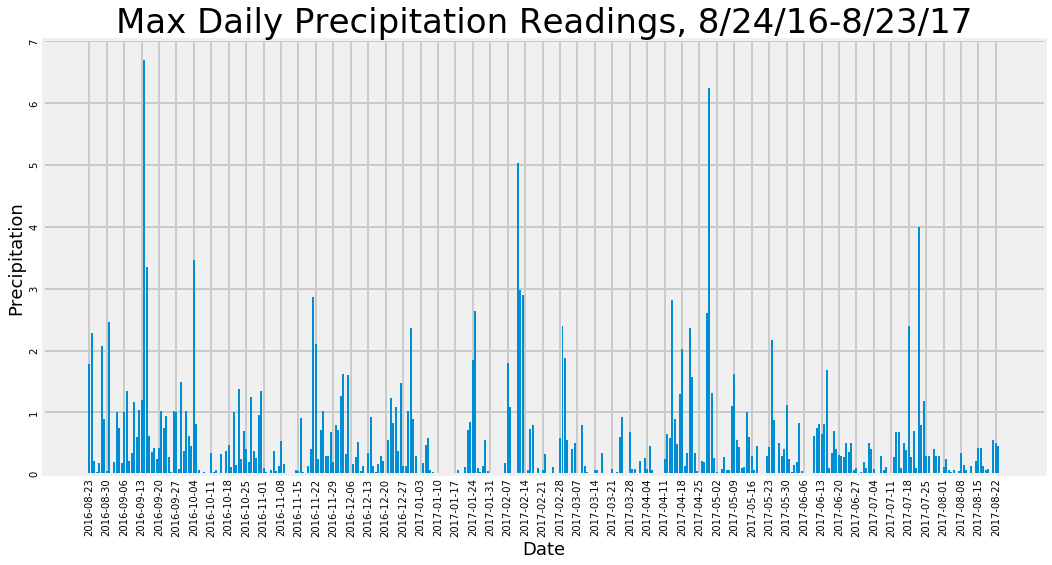

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(16, 8))
plt.xticks(np.arange(0, 365, 7))
plt.tick_params(width=36, labelrotation = 90)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Precipitation", fontsize=18)
plt.grid(linewidth=2)
plt.title("Max Daily Precipitation Readings, 8/24/16-8/23/17", fontsize=34)

plt.bar(measurement_df.index,measurement_df['prcp'], label = "precipitation")


![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

measurement_df.describe()

,prcp
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


![describe](Images/describe.png)

In [14]:
columns = inspector.get_columns('Station')

for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Station).count()
stations

9

In [42]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stationdata_df = pd.DataFrame(engine.execute("SELECT s.station, s.name, m.date, m.prcp, m.tobs FROM Station S \
LEFT JOIN Measurement M WHERE s.station = m.station ORDER BY s.name").fetchall())
stationdata_df.columns = ['station','name','date','prcp','tobs']

station_activity = stationdata_df.groupby('station', as_index=False)['name'].count()
station_activity = station_activity.sort_values('name',ascending=False)

highest_activity = station_activity.iloc[0,0]

station_activity


,station,name
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


funcs = session.query(func.max(Measurement.tobs).label("max"), 
                    func.min(Measurement.tobs).label("min"),
                    func.avg(Measurement.tobs).label('avg')
                    ).filter(Measurement.station == highest_activity).all()

funcs

[(85.0, 54.0, 71.66378066378067)]

(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 53., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

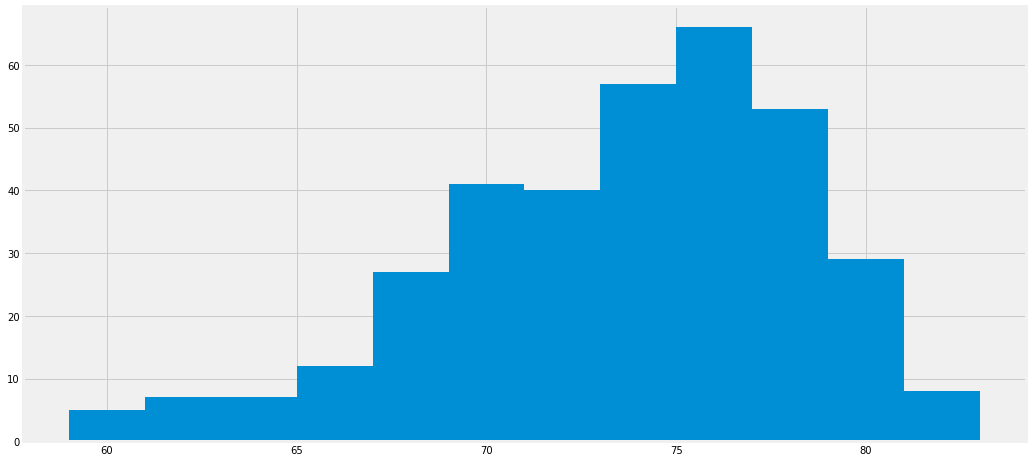

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


tobs_df = pd.DataFrame(session.query(Measurement.date, Measurement.tobs)\
                       .filter(Measurement.date >= query_date).filter(Measurement.station == highest_activity).all())

plt.figure(figsize=(16, 8))
plt.tight_layout
plt.hist(tobs_df.tobs, bins=12)

![precipitation](Images/station-histogram.png)

In [48]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-07-09', '2012-07-16'))

[(70.0, 74.78333333333333, 82.0)]


In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = dt.date(2018,1,20) - dt.timedelta(days=365)
end_date = dt.date(2018,1,27) - dt.timedelta(days=365)

start = start_date.strftime('%Y-%m-%d')
end = end_date.strftime('%Y-%m-%d')

tick="'"

start1 = tick+start+tick
end1=tick+end+tick

temps = calc_temps(start, end)[0]

temps



(63.0, 70.88461538461539, 77.0)

<BarContainer object of 1 artists>

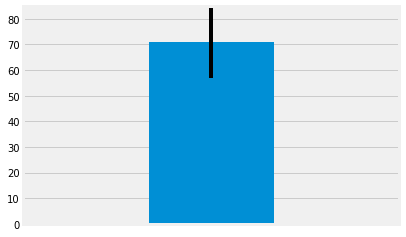

In [50]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.xticks(np.arange(0,0))
plt.margins(1,0)
plt.bar(1,temps[1], yerr = temps[2] - temps[0])


In [51]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


vacation_precip = pd.DataFrame(engine.execute("SELECT s.station, s.name, m.date, m.tobs, s.latitude, s.longitude, s.elevation FROM Station s \
LEFT JOIN Measurement m WHERE m.station = s.station AND m.date >= "+start1+" AND m.date <="+end1+" ORDER BY s.name").fetchall())
vacation_precip.columns = ['station', 'name','date','tobs','lat','lon','elevation']
vacation_precip_totals = vacation_precip.groupby('name').agg({'tobs':'sum','lat':'mean','lon':'mean','elevation':'mean'}).rename(columns={'tobs':'Total Rainfall'})

vacation_precip_totals


,Total Rainfall,lat,lon,elevation
name,,,,
"KANEOHE 838.1, HI US",566.0,21.42340,-157.80150,14.6
"KUALOA RANCH HEADQUARTERS 886.9, HI US",443.0,21.52130,-157.83740,7.0
"MANOA LYON ARBO 785.2, HI US",544.0,21.33310,-157.80250,152.4
"PEARL CITY, HI US",420.0,21.39340,-157.97510,11.9
"WAIHEE 837.5, HI US",560.0,21.45167,-157.84889,32.9
"WAIKIKI 717.2, HI US",564.0,21.27160,-157.81680,3.0
"WAIMANALO EXPERIMENTAL FARM, HI US",589.0,21.33556,-157.71139,19.5


## Optional Challenge Assignment

In [52]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")



[(62.0, 69.15384615384616, 77.0)]

In [53]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings
delta = end_date - start_date

normals=[]
for i in range(delta.days + 1):
    y=(start_date + dt.timedelta(days=i)).strftime('%m-%d')
    normals.append(y)

normals

['01-20', '01-21', '01-22', '01-23', '01-24', '01-25', '01-26', '01-27']

In [25]:
# Loop through the list of %m-%d strings and calculate the normals for each date

import ast

normals_list=[]

for z in normals:
    daystats = daily_normals(z)
    minz=daystats[0][0]
    avgz=daystats[0][1]
    maxz=daystats[0][2]
    dictz="{'trip_dates':'" + z + "','min_temp':" + str(minz) +",'avg_temp':" + str(avgz) + ",'max_temp':" + str(maxz)+"}"
    res = ast.literal_eval(dictz)
    normals_list.append(res)
    
normals_list



[{'trip_dates': '01-20',
  'min_temp': 61.0,
  'avg_temp': 68.86666666666666,
  'max_temp': 78.0},
 {'trip_dates': '01-21',
  'min_temp': 61.0,
  'avg_temp': 70.14545454545454,
  'max_temp': 76.0},
 {'trip_dates': '01-22',
  'min_temp': 60.0,
  'avg_temp': 69.26415094339623,
  'max_temp': 76.0},
 {'trip_dates': '01-23',
  'min_temp': 57.0,
  'avg_temp': 69.50909090909092,
  'max_temp': 79.0},
 {'trip_dates': '01-24',
  'min_temp': 58.0,
  'avg_temp': 68.76271186440678,
  'max_temp': 78.0},
 {'trip_dates': '01-25',
  'min_temp': 61.0,
  'avg_temp': 67.94915254237289,
  'max_temp': 75.0},
 {'trip_dates': '01-26',
  'min_temp': 61.0,
  'avg_temp': 70.58620689655173,
  'max_temp': 77.0},
 {'trip_dates': '01-27',
  'min_temp': 59.0,
  'avg_temp': 68.56896551724138,
  'max_temp': 75.0}]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals_list)
normals_df

,trip_dates,min_temp,avg_temp,max_temp
0,01-20,61.0,68.866667,78.0
1,01-21,61.0,70.145455,76.0
2,01-22,60.0,69.264151,76.0
3,01-23,57.0,69.509091,79.0
4,01-24,58.0,68.762712,78.0
5,01-25,61.0,67.949153,75.0
6,01-26,61.0,70.586207,77.0
7,01-27,59.0,68.568966,75.0


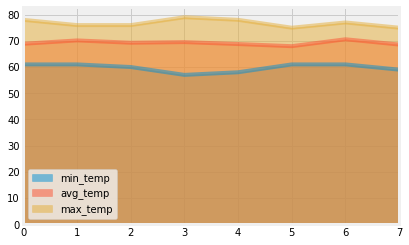

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
ax=normals_df.plot.area(stacked=False)